In [1]:
# -*- coding:utf-8 -*-
%matplotlib inline
import os
# 设置环境变量（放在import tf前才生效）
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# import tensorflow as tf
import tensorflow.compat.v1 as tf
import tensorflow.keras as keras
# import tensorflow._api.v2.compat.v1 as tf
# tf.disable_v2_behavior()
# tf.enable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.utils import shuffle
from glob import glob
import pickle
from tqdm import tqdm # 进度条库

from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv1D, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint

from python_speech_features import mfcc # 提取音频特征，用pip安装
import librosa # 音频处理 用conda安装
from IPython.display import Audio
import wave

from sklearn.model_selection import train_test_split


In [2]:
# 测试 tensorflow-gpu
print(tf.__version__)
print(tf.test.is_gpu_available()) # 提示使用新方法
# print(tf.config.list_physical_devices('GPU')) # 新方法查看可用GPU

1.15.0
True


In [3]:
# 设置GPU

from warnings import simplefilter

# 设置GPU定量分配
config = tf.ConfigProto() # config = tf.ConfigProto() tensorflow v1和v2不同
# config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 占用GPU90%的显存
# session = tf.Session(config=config) # session = tf.compat.v1.Session(config=config)
session = tf.Session(config=config)

# 设置GPU按需分配
config = tf.ConfigProto()
# config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
session = tf.Session(config=config)

simplefilter(action='ignore', category=FutureWarning)


In [4]:
# 获取指定路径下所有的pcm文件

files = glob(r'D:\Users\GraduationDesign\AudioProcessed\*\*.wav')

train_files, vad_files = train_test_split(files, test_size=0.99, random_state=40)

train_files, vad_files = train_test_split(train_files, test_size=0.2, random_state=40)

print(len(train_files), len(vad_files), train_files[0])

1344 336 D:\Users\GraduationDesign\AudioProcessed\Henan\T0045G0033S0087.wav


In [5]:
labels = {'train': [], 'vad': []} # 训练集和验证集

for i in tqdm(range( len(train_files) )):
    path = train_files[i]
    label = path.split('\\')[4] # 3
    labels['train'].append(label)

for i in tqdm(range( len(vad_files) )):
    path = vad_files[i]
    label = path.split('\\')[4]
    labels['vad'].append(label)

print(len(labels['train']), len(labels['vad']))

100%|██████████| 336/336 [00:00<00:00, 333007.12it/s]

1344 336


In [6]:
mfcc_dim = 13       # 通道数为13
sr = 16000          # 采样率为16000
min_length = 1 * sr
slice_length = 3 * sr


#定义加载并处理语音函数
def load_and_trim(path, sr=16000):                  # memmap对象，它允许将大文件分成小段进行读写，而不是一次性将整个数组读入内存。
    # audio = np.memmap(path, dtype='h', mode='r')  # 使用函数np.memmap并传入一个文件路径、数据类型、形状以及文件模式
    f = wave.open(path, 'rb')
    
    params = f.getparams()
    nchannels,sampwidth,framerate,nframers = params[:4]
    str_data = f.readframes(nframers)
    f.close()
    audio = np.frombuffer(str_data, dtype='h')  # 从fromstring修改
    
    audio = audio[2000:-2000]                           # b = a[i:j] 表示复制a[i]到a[j-1]，为负数时表示倒数几个，以生成新的list对象
    audio = audio.astype(np.float32)                    # astype()：类型转换为float32
    energy = librosa.feature.rms(y=audio)                 # 调用librosa中的rmse直接对音频每个帧进行计算得到均方根能量
    frames = np.nonzero(energy >= np.max(energy) / 5)   # 返回大于五分之一最大能量的能量索引
    indices = librosa.core.frames_to_samples(frames)[1] # librosa.core.frames_to_samples():将帧索引转换为音频样本索引
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0] # audio中存放去除头尾空白音频部分，
    
    slices = []
    for i in range(0, audio.shape[0], slice_length):    # 对长语音片段分片，shape数组大小
        s = audio[i: i + slice_length]
        if s.shape[0] >= min_length:
            slices.append(s)            # append在列表尾插入元素，slices中存放分片后的音频信号
    
    return audio, slices

In [7]:
# pcm文件转为wav函数:
## pcm存储的是int型整数，不含任何采样率相关信息。
## wav存储的一般是解码后为[-1, 1]的float数据，文件头有44个字节记录文件的采样率、长度等等信息。
def pcm2wav(pcm_path, wav_path, channels=1, bits=16, sample_rate=sr):
    data = open(pcm_path, 'rb').read()  # 只读
    fw = wave.open(wav_path, 'wb')      # 只写
    fw.setnchannels(channels)           # 设置声道数
    fw.setsampwidth(bits // 8)          # 设置采样位数
    fw.setframerate(sample_rate)        # 设置采样率
    fw.writeframes(data)                # 写入数据

    fw.close()

In [8]:
# 可视化语音
def visualize(index, source='train'):
    if source == 'train':
        path = train_files[index]
    else:
        path = vad_files[index]
    print(path)

    #画出原始信号在时域中具有的形式
    audio, slices = load_and_trim(path)
    print('Duration: %.2f s' % (audio.shape[0] / sr))
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()

    # 获取13维的 MFCC 特征
    feature = mfcc(audio, sr, numcep=mfcc_dim)
    print('Shape of MFCC:', feature.shape)

    # 画出MFCC特征图的频谱图
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()
    
    # wav_path = 'example.wav'
    # pcm2wav(path, wav_path)
    
    return path


D:\Users\GraduationDesign\AudioProcessed\Hangzhou\T0082G0007S0171.wav
Duration: 5.63 s


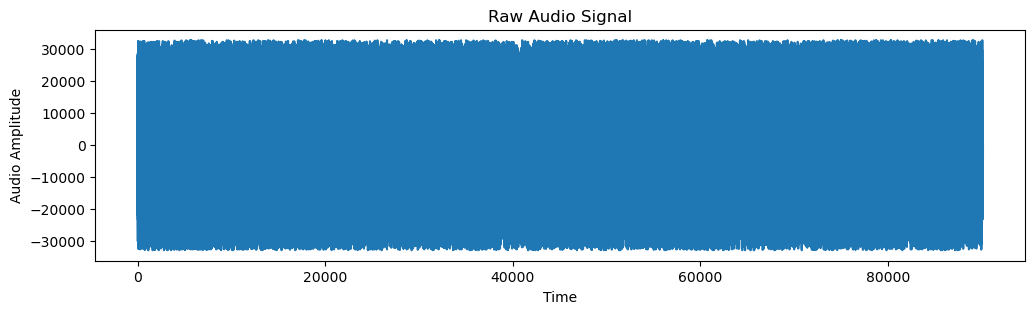

Shape of MFCC: (562, 13)


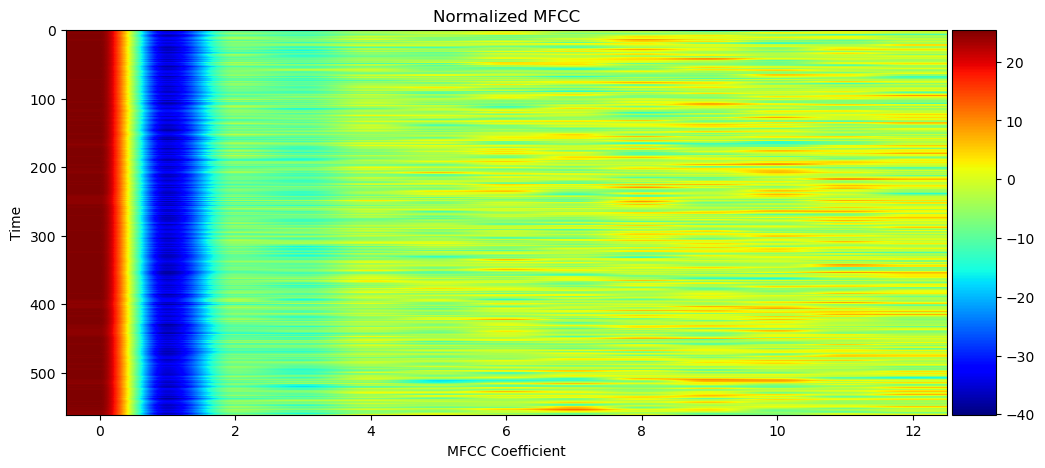

In [9]:
Audio(visualize(2))

2023-3-20 22:14:39


100%|██████████| 1344/1344 [00:10<00:00, 133.44it/s]


2023-3-20 22:14:49


100%|██████████| 336/336 [00:02<00:00, 142.79it/s]


1916 475


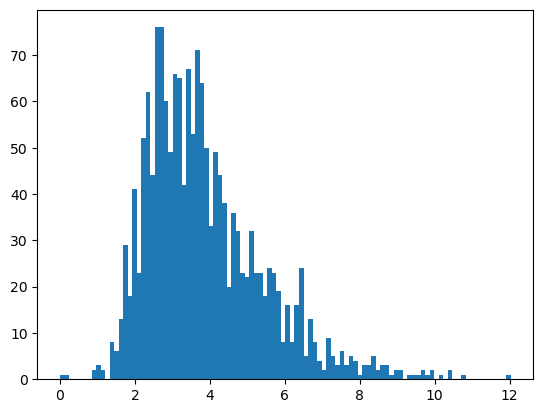

In [10]:
# 整理数据并查看语音片段的时长分布
X_train = []    # 特征的训练集
X_vad = []      # 特征的测试集
Y_train = []    # 标签的训练集
Y_vad = []      # 标签的测试集
lengths = []    # 各语音片段长度
import time
import functools

func_mfcc = functools.partial(mfcc, samplerate=sr,numcep=mfcc_dim)

localtime = time.localtime()
print('%s-%s-%s %02s:%02s:%02s'%(localtime.tm_year, localtime.tm_mon, localtime.tm_mday, 
                                 localtime.tm_hour, localtime.tm_min, localtime.tm_sec))
# 对训练集语音分片后各片段进行MFCC特征提取以及与标签对应
for i in tqdm(range(len(train_files))):
    path = train_files[i]
    audio, slices = load_and_trim(path)
    lengths.append(audio.shape[0] / sr)

    for s in slices:
        X_train.append(mfcc(s, samplerate=sr, numcep=mfcc_dim))
        Y_train.append(labels['train'][i])


localtime = time.localtime()
print('%s-%s-%s %02s:%02s:%02s'%(localtime.tm_year,localtime.tm_mon, localtime.tm_mday, localtime.tm_hour, localtime.tm_min, localtime.tm_sec))

# 对测试集语音分片后各片段进行MFCC特征提取以及与标签对应
for i in tqdm(range(len(vad_files))):
    path = vad_files[i]
    audio, slices = load_and_trim(path)
    lengths.append(audio.shape[0] / sr)
    for s in slices:
        X_vad.append(mfcc(s, sr, numcep=mfcc_dim))
        Y_vad.append(labels['vad'][i])

# # 读取保存的已处理过的数据
# import pickle as pk
# handled_data = {'X_train': X_train, 'Y_train': Y_train, 'X_vad': X_vad, 'Y_vad': Y_vad}
# fp = open('saved_data','rb')
# handled_data = pk.load(fp)
# fp.close()
# X_train, Y_train, X_vad, Y_vad, lengths = handled_data['X_train'], handled_data['Y_train'], handled_data['X_vad'], handled_data['Y_vad'], handled_data['lengths']

print(len(X_train), len(X_vad))
plt.hist(lengths, bins=100)
plt.show()

In [11]:
# 保存已提取特征的数据到本地

import pickle as pk
handled_data = {'X_train': X_train, 'Y_train': Y_train, 'X_vad': X_vad, 'Y_vad': Y_vad, 'lengths':lengths}
fp = open(r'saved_data', 'wb')
pk.dump(handled_data, fp)
fp.close()


In [12]:
#对mfcc特征进行归一化
samples = np.vstack(X_train)  # vstack()将数据整合到一个数组中
mfcc_mean = np.mean(samples, axis=0) # 求均值，axis = 0：压缩行，对各列求均值，返回 1* n 矩阵
mfcc_std = np.std(samples, axis=0) # 求标准差

X_train = [(x - mfcc_mean) / (mfcc_std + 1e-14) for x in X_train]
X_vad = [(x - mfcc_mean) / (mfcc_std + 1e-14) for x in X_vad]

maxlen = np.max([x.shape[0] for x in X_train + X_vad])
X_train = pad_sequences(X_train, maxlen, 'float32', padding='post', value=0.0)
X_vad = pad_sequences(X_vad, maxlen, 'float32', padding='post', value=0.0)
print(X_train.shape, X_vad.shape)

(1916, 299, 13) (475, 299, 13)


In [13]:
 #对分类标签进行处理
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)  #用0，1，2，3...表示不同类别
Y_vad = le.transform(Y_vad)
print(le.classes_)

class2id = {c: i for i, c in enumerate(le.classes_)}  #标签与数字之间对应关系
id2class = {i: c for i, c in enumerate(le.classes_)}

num_class = len(le.classes_)
Y_train = to_categorical(Y_train, num_class) #将类别向量转化为独热编码的矩阵向量
Y_vad = to_categorical(Y_vad, num_class)
print(Y_train.shape, Y_vad.shape)

['Hangzhou' 'Henan' 'Minnan' 'Shanghai' 'Sichuan' 'Suzhou' 'Yueyu']
(1916, 7) (475, 7)


In [14]:
#定义产生批数据的迭代器
batch_size = 16

def batch_generator(x, y, batch_size=batch_size):
    offset = 0
    while True:
        offset += batch_size

        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)  #shyffle():对多个等长列表打乱，并且保证一一对应关系不变
            offset = batch_size
        
        X_batch = x[offset - batch_size: offset]
        Y_batch = y[offset - batch_size: offset]
        yield (X_batch, Y_batch)

In [15]:
# 定义模型并训练通过GloblMaxPooling1D对整个序列的输出进行降维，从而变成标准的分类任务
from tensorflow.keras.layers import BatchNormalization, Activation, Multiply, Add, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)
# 批量标准化
def batchnorm(inputs):
    return BatchNormalization()(inputs)
# 激活函数
def activation(inputs, activation):
    return Activation(activation)(inputs)
# 残差块，实现门控激活机制
def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])

    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')

    return Add()([ha, inputs]), hs #残差层输出和跳连接层输出

In [16]:
epochs = 30
num_blocks = 3
filters = 128
drop_rate = 0.2
# model_wt_pth = r'model_wt.index'

X = Input(shape=(None, mfcc_dim,), dtype='float32')
h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu') # batch_size, seq_len, filters
h1 = batchnorm(conv1d(h1, num_class, 1, 1)) # batch_size, seq_len, num_class
h1 = Dropout(drop_rate)(h1)
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class
Y = activation(h1, 'softmax')

optimizer = Adam(lr=0.01, clipnorm=5) # 原 0.01
model = Model(inputs=X, outputs=Y)
# 加载权重
# if os.path.exists(model_wt_pth):
#     print('加载模型权重')
#     model.load_weights(model_wt_pth)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # 原loss = 'categorical_crossentropy'

checkpointer = ModelCheckpoint(filepath='WaveNet_model.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=1, min_lr=0.001)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
history = model.fit_generator(
    generator=batch_generator(X_train, Y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=batch_generator(X_vad, Y_vad),
    validation_steps=len(X_vad) // batch_size,
    callbacks=[checkpointer, lr_decay])

Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
119/119 [==============================] - 141s 1s/step - loss: 1.9936 - acc: 0.1555 - val_loss: 1.9972 - val_acc: 0.1703
Epoch 2/30
119/119 [==============================] - 59s 495ms/step - loss: 1.9168 - acc: 0.1817 - val_loss: 1.9392 - val_acc: 0.1681
Epoch 3/30
119/119 [==============================] - 58s 485ms/step - loss: 1.8618 - acc: 0.2694 - val_loss: 1.9238 - val_acc: 0.1573
Epoch 4/30
119/119 [==============================] - 61s 514ms/step - loss: 1.7876 - acc: 0.3235 - val_loss: 1.9241 - val_acc: 0.1918
Epoch 5/30
119/119 [==============================] - 60s 508ms/step - loss: 1.6889 - acc: 0.3824 - val_loss: 1.9341 - val_acc: 0.1681
Epoch 6/30
119/119 [==============================] - 64s 535ms/step - loss: 1.5293 - acc: 0.4464 - val_loss: 1.9815 - val_acc: 0.1703
Epoch 7/30
119/119 [==============================] - 62s 519ms/step - loss: 1.2135 - acc: 0.5987 

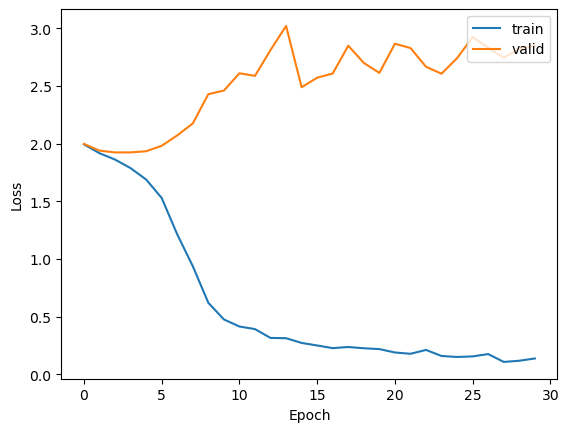

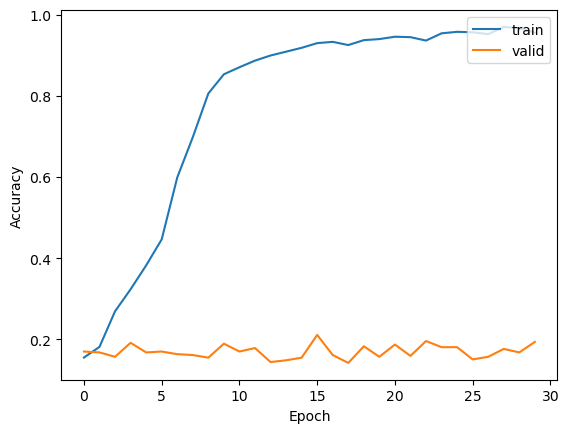

In [19]:
#绘制损失函数和正确率曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Loss.jpg')
plt.show()

train_acc = history.history['acc']
valid_acc = history.history['val_acc']
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('Acc.jpg')
plt.show()


In [ ]:
#保存方言与标签之间的映射
with open('resources.pkl', 'wb') as fw:
    pickle.dump([class2id, id2class, mfcc_mean, mfcc_std], fw)

In [ ]:
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import sklearn
# from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
#
#
# # 绘制正例ROC曲线
# def plot_roc(name, labels, predictions, **kwargs):
#     fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions, pos_label=0)
#
#     plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
#     plt.xlabel('False positives [%]')
#     plt.ylabel('True positives [%]')
#     plt.xlim([-0.5, 100.5])
#     plt.ylim([-0.5, 100.5])
#     plt.grid(True)
#     ax = plt.gca()
#     ax.set_aspect('equal')
#     plt.legend(loc='lower right')
#     plt.savefig("./img/multi_roc.png")
#
# np.seterr(divide='ignore',invalid='ignore')
# pred = model.predict(X_vad)
# test_predictions = np.argmax(pred, axis=1)
# true = Y_vad
# test_scores = 1 - (test_predictions - test_predictions.min()) / (test_predictions.max() - test_predictions.min())
#
# mpl.rcParams['figure.figsize'] = (12, 10)
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# plot_roc("My Model", X_vad, test_scores, color=colors[0])
#
# acc = accuracy_score(true, test_predictions)
# recall = recall_score(true, test_predictions, average='micro')
# precision = precision_score(true, test_predictions, average='micro')
# f1 = f1_score(true, test_predictions, average='micro')
# print('accuracy: ', acc)
# print('recall: ', recall)
# print('precision: ', precision)
# print('f1: ', f1)

In [ ]:
# from functools import reduce
# from operator import mul
# import tensorflow as tf
#
# def get_num_params():
#     num_params = 0
#     for variable in tf.trainable_variables():
#         shape = variable.get_shape()
#         num_params += reduce(mul, [dim.value for dim in shape], 1)
#     return num_params
# print(get_num_params())